# Duds During Darden's Duration:
## Anomaly Detection in Access Logs
#### Kwame V. Taylor

Project Description Here.

### Imports

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots
%matplotlib inline
import seaborn as sns

# default viz size settings
plt.rc('figure', figsize=(14, 9))
plt.rc('font', size=15)

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

# importing GeoIP database for IP geolocation
import geoip2.database
reader = geoip2.database.Reader('GeoLite2City/GeoLite2-City.mmdb')

# import system to check errors
import sys

### Acquire

In [2]:
colnames = ['date', 'timestamp', 'request_method', 'user_id', 'cohort_id', 'ip']

df = pd.read_csv('anonymized-curriculum-access.txt', header=None, index_col=False,
                 names=colnames, delim_whitespace=True, na_values='"-"')
#                 usecols=[0, 1, 2, 5])
df.head()

,date,timestamp,request_method,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22,97.105.19.61


### Prepare

In [3]:
# merge date and timestamp
df["ds"] = df["date"] +" "+ df["timestamp"]
df.head()

,date,timestamp,request_method,user_id,cohort_id,ip,ds
0,2018-01-26,09:55:03,/,1,8,97.105.19.61,2018-01-26 09:55:03
1,2018-01-26,09:56:02,java-ii,1,8,97.105.19.61,2018-01-26 09:56:02
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,2018-01-26 09:56:05
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,2018-01-26 09:56:06
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22,97.105.19.61,2018-01-26 09:56:24


In [4]:
# drop date and timestamp
df = df.drop(columns=['date', 'timestamp'])
df.head()

,request_method,user_id,cohort_id,ip,ds
0,/,1,8,97.105.19.61,2018-01-26 09:55:03
1,java-ii,1,8,97.105.19.61,2018-01-26 09:56:02
2,java-ii/object-oriented-programming,1,8,97.105.19.61,2018-01-26 09:56:05
3,slides/object_oriented_programming,1,8,97.105.19.61,2018-01-26 09:56:06
4,javascript-i/conditionals,2,22,97.105.19.61,2018-01-26 09:56:24


In [5]:
# convert date column to datetime type
df.ds = pd.to_datetime(df.ds)
df.dtypes

request_method            object
user_id                    int64
cohort_id                 object
ip                        object
ds                datetime64[ns]
dtype: object

In [6]:
# set ds as index and sort
# this is a very important step!
df = df.set_index('ds').sort_index()
df.head()

,request_method,user_id,cohort_id,ip
ds,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61


In [7]:
df.shape

(719459, 4)

In [8]:
df.request_method.value_counts()

/                                          40122
search/search_index.json                   15393
javascript-i                               14551
toc                                        14018
java-iii                                   10835
                                           ...  
6_Project.json                                 1
codeup-exercises                               1
ltc-ml/slides/1                                1
appendix/extra-exercises/javascript            1
further-reading/javascript/array-splice        1
Name: request_method, Length: 2154, dtype: int64

In [9]:
df.ip.value_counts()

97.105.19.58       268648
97.105.19.61        60530
192.171.117.210      8896
71.150.217.33        4919
12.106.208.194       4262
                    ...  
174.207.16.31           1
174.244.81.91           1
70.238.240.119          1
99.203.90.36            1
184.203.15.95           1
Name: ip, Length: 4064, dtype: int64

In [10]:
df.cohort_id.nunique()

386

Some IP addresses accidentally got put in the ```cohort_id``` column, so I'm going to drop those rows.

In [11]:
df = df.drop(df[df.cohort_id.str.len() > 4].index)
df

,request_method,user_id,cohort_id,ip
ds,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61
...,...,...,...,...
2020-11-02 16:48:13,javascript-i/coffee-project,763,62,107.192.148.199
2020-11-02 16:48:17,javascript-i/mapbox-api,771,62,172.125.226.175
2020-11-02 16:48:18,javascript-i/coffee-project,771,62,172.125.226.175


In [12]:
#sample code from ryan, for reference
#mask = (df.column.str.contains(“A”) | df.column.str.contains(“B”))
#df[mask]

**Drop nulls**

In [13]:
df.isna().sum()

request_method      0
user_id             0
cohort_id         420
ip                  0
dtype: int64

In [14]:
df = df.dropna()

I noticed there are some requests that are just ```/```. In the interest of time, I am choosing to just drop those rows for now, as I didn't see any pattern to the distrubution of them and assume it's something to do with the syntax reading read in wrong or there being missing data in the raw data file I imported.

**Drop bad request_methods**

In [15]:
# there are over 10,000 of these '/' requests
df.groupby(['request_method']).filter(lambda x : len(x)>10000).head(3)

,request_method,user_id,cohort_id,ip
ds,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61
2018-01-26 10:00:37,/,6,22,97.105.19.61
2018-01-26 10:00:39,javascript-i,6,22,97.105.19.61


In [16]:
df = df.drop(df[df.request_method.str.len() < 2].index)
df.head()

,request_method,user_id,cohort_id,ip
ds,,,,
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61
2018-01-26 09:56:41,javascript-i/loops,2,22,97.105.19.61


**Split IP address into network and host**
 * **Reference**: https://docs.oracle.com/cd/E19504-01/802-5753/planning3-18471/index.html

In [17]:
df[['network1','network2', 'host1', 'host2']] = df.ip.str.split(".",expand=True)
df.head()

,request_method,user_id,cohort_id,ip,network1,network2,host1,host2
ds,,,,,,,,
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,97,105,19,61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,97,105,19,61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,97,105,19,61
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,97,105,19,61
2018-01-26 09:56:41,javascript-i/loops,2,22,97.105.19.61,97,105,19,61


In [18]:
df['network'] = df['network1'] + df['network2']
df['host'] = df['host1'] + df['host2']
df.head()

,request_method,user_id,cohort_id,ip,network1,network2,host1,host2,network,host
ds,,,,,,,,,,
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,97,105,19,61,97105,1961
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,97,105,19,61,97105,1961
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,97,105,19,61,97105,1961
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,97,105,19,61,97105,1961
2018-01-26 09:56:41,javascript-i/loops,2,22,97.105.19.61,97,105,19,61,97105,1961


**I notice that there is at least one instance of a different user_id under the same exact IP address. Might be a typo, or just something I don't understand about IP addresses.**

In [19]:
df = df.drop(columns=['network1', 'network2', 'host1', 'host2'])
df.head()

,request_method,user_id,cohort_id,ip,network,host
ds,,,,,,
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,97105,1961
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,97105,1961
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,97105,1961
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,97105,1961
2018-01-26 09:56:41,javascript-i/loops,2,22,97.105.19.61,97105,1961


In [20]:
df.network.nunique()

700

In [21]:
df.host.nunique()

3727

### Explore & Feature Engineering

In [22]:
# create dataframe out of value counts
ip_counts = pd.DataFrame(df.ip.value_counts()).reset_index()

# rename columns
ip_counts.columns=['ip', 'event_count']

# get the number of ip addresses seen 1, or 2, or 11,998 times. 
ip_counts.groupby(['event_count']).count()

,ip
event_count,
1,537
2,511
3,313
4,238
5,184
...,...
4077,1
4590,1
8447,1


In [23]:
# pass the entropy function an array-like object of counts. 
entropy(ip_counts.event_count)

4.149481083203116

**Make darden_df for just dates from Darden cohort**

In [24]:
df.tail(2)

,request_method,user_id,cohort_id,ip,network,host
ds,,,,,,
2020-11-02 16:48:28,javascript-i/bom-and-dom/bom,771,62,172.125.226.175,172125,226175
2020-11-02 16:48:47,javascript-i/bom-and-dom/bom,763,62,107.192.148.199,107192,148199


In [25]:
darden_df = df.loc['2020-07-13':'2020-11-02']
darden_df.head(2)

,request_method,user_id,cohort_id,ip,network,host
ds,,,,,,
2020-07-13 00:00:19,appendix,633,57,24.26.242.224,2426,242224
2020-07-13 00:00:23,appendix/professional-development/linkedin-tips,633,57,24.26.242.224,2426,242224


In [26]:
darden_df.shape

(98631, 6)

### Geolocation Exploration

**Add City Feature**

In [27]:
def add_city(ip):
    try:
        response = reader.city(ip)
        city_name = response.city.name
        return city_name
    except:
        return np.nan

In [28]:
darden_df['city'] = darden_df.apply(lambda darden_df: add_city(darden_df['ip']),axis=1)

In [29]:
darden_df.head()

,request_method,user_id,cohort_id,ip,network,host,city
ds,,,,,,,
2020-07-13 00:00:19,appendix,633,57,24.26.242.224,2426,242224,San Antonio
2020-07-13 00:00:23,appendix/professional-development/linkedin-tips,633,57,24.26.242.224,2426,242224,San Antonio
2020-07-13 00:04:59,appendix/professional-development/cover-letter,614,56,174.67.1.123,17467,1123,Oklahoma City
2020-07-13 00:05:49,spring/fundamentals/security/authentication,606,56,76.187.7.114,76187,7114,Garland
2020-07-13 00:52:09,javascript-i/arrays,672,58,67.11.50.23,6711,5023,Boerne


In [30]:
darden_df.city.nunique()

105

In [31]:
darden_df.city.value_counts()

San Antonio      68077
Dallas            5451
Boerne            3315
New Braunfels     1966
Austin            1491
                 ...  
Pflugerville         1
Bulverde             1
Floresville          1
Beaumont             1
Marfa                1
Name: city, Length: 105, dtype: int64

In [32]:
darden_df.shape

(98631, 7)

In [33]:
city_plot_df = darden_df.groupby('city').filter(lambda x : len(x)>900)
city_plot_df.city.nunique()

11

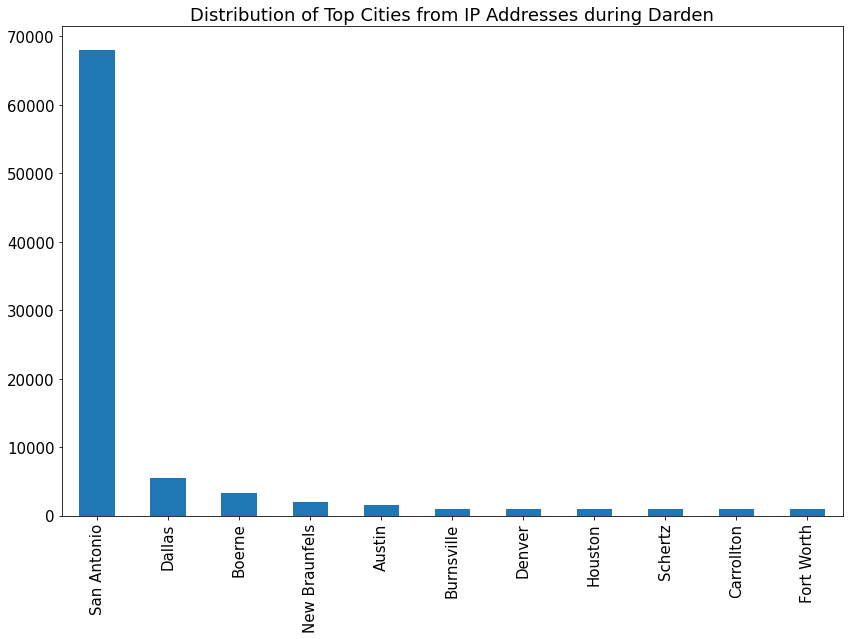

In [34]:
city_plot_df['city'].value_counts().plot(kind='bar')
plt.title('Distribution of Top Cities from IP Addresses during Darden')
plt.show()

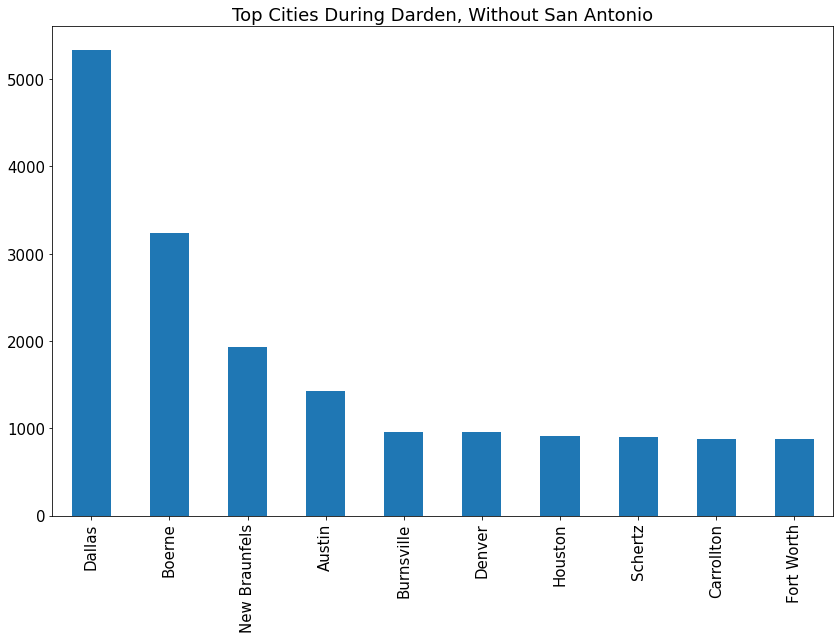

In [35]:
city_plot_df['city'].drop(city_plot_df[city_plot_df.city == 'San Antonio'].index).value_counts().plot(kind='bar')
plt.title('Top Cities During Darden, Without San Antonio')
plt.show()

In [36]:
city_plot_anomalies = darden_df.groupby('city').filter(lambda x : len(x)<3)
city_plot_anomalies.city.nunique()

15

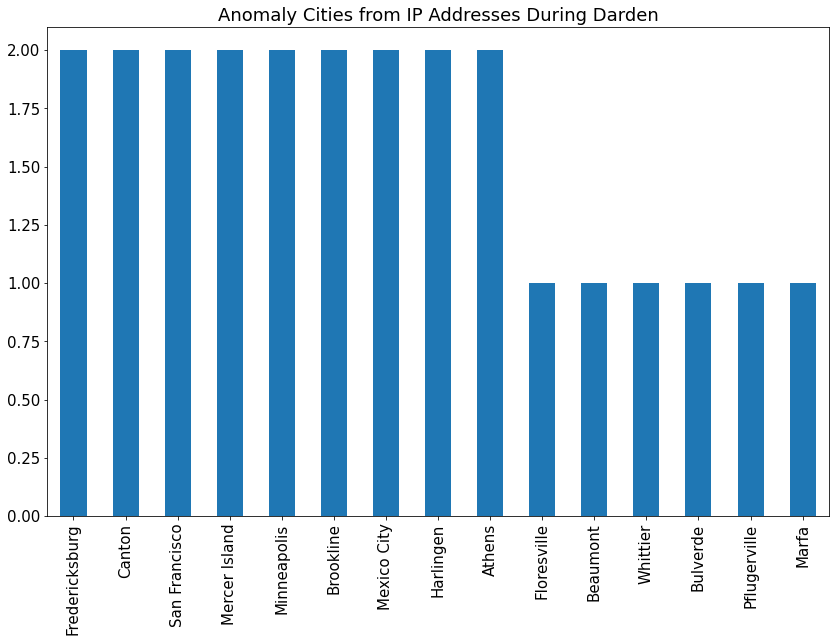

In [37]:
city_plot_anomalies['city'].value_counts().plot(kind='bar')
plt.title('Anomaly Cities from IP Addresses During Darden')
plt.show()

**Takeaways:** Athens, Mexico City, and Palestine (it seems GeoLite couldn't acquire the city in some places and gave me the country instead) are all in other countries, so I'm going to see if I can zoom in on geolocations from outside the USA.

**Create Country feature**

Note: Still working with just the Darden duration data so that my geolocation code isn't too computationally expensive.

In [43]:
def add_country(ip):
    try:
        response = reader.city(ip)
        country_name = response.country.name
        return country_name
    except:
        return np.nan

In [44]:
darden_df['country'] = darden_df.apply(lambda darden_df: add_country(darden_df['ip']),axis=1)

In [ ]:
darden_df.country.nunique()
darden_df.country.value_counts()
country_plot_df = darden_df.groupby('country').filter(lambda x : len(x)>900)
country_plot_df.country.nunique()

In [59]:
darden_df.head()

,request_method,user_id,cohort_id,ip,network,host,city,country
ds,,,,,,,,
2020-07-13 00:00:19,appendix,633,57,24.26.242.224,2426,242224,San Antonio,NaN
2020-07-13 00:00:23,appendix/professional-development/linkedin-tips,633,57,24.26.242.224,2426,242224,San Antonio,NaN
2020-07-13 00:04:59,appendix/professional-development/cover-letter,614,56,174.67.1.123,17467,1123,Oklahoma City,NaN
2020-07-13 00:05:49,spring/fundamentals/security/authentication,606,56,76.187.7.114,76187,7114,Garland,NaN
2020-07-13 00:52:09,javascript-i/arrays,672,58,67.11.50.23,6711,5023,Boerne,NaN


**Look for Suspicious IPs in the City NaNs**

It's possible that the city for some IP addresses was unable to be acquired because of suspicious reasons. 

Let's investigate.

Reference: https://ipremoval.sms.symantec.com/ipr/lookup

I tested the reference on my own IP address for a quick check of it's validity, and it came back with "no bad reputation" for my IP address.

In [60]:
darden_df.isna().sum()

request_method        0
user_id               0
cohort_id             0
ip                    0
network               0
host                  0
city                185
country           98631
dtype: int64

In [65]:
darden_df[darden_df.city.isna()]

,request_method,user_id,cohort_id,ip,network,host,city,country
ds,,,,,,,,
2020-07-13 10:14:49,spring/fundamentals/views,615,56,107.242.125.32,107242,12532,None,NaN
2020-07-13 11:19:32,html-css/elements,615,56,107.242.125.32,107242,12532,None,NaN
2020-07-13 11:19:46,html-css/forms,615,56,107.242.125.32,107242,12532,None,NaN
2020-07-13 11:20:03,html-css/css-i,615,56,107.242.125.32,107242,12532,None,NaN
2020-07-13 11:20:04,html-css/css-i/introduction,615,56,107.242.125.32,107242,12532,None,NaN
...,...,...,...,...,...,...,...,...
2020-11-02 13:33:07,jquery,769,62,98.39.66.72,9839,6672,None,NaN
2020-11-02 13:33:12,javascript-i,769,62,98.39.66.72,9839,6672,None,NaN
2020-11-02 13:33:16,javascript-i/bom-and-dom,769,62,98.39.66.72,9839,6672,None,NaN


**Takeaways:** Using https://ipremoval.sms.symantec.com/ipr/lookup, I searched for ```107.242.125.32``` and it returned:

>The IP Address 107.242.125.32 was found to have a negative reputation. Reasons for this assessment include:
>* The host has been observed sending spam in a format that is similar to snow shoe spamming techniques.
>* The host is unauthorized to send email directly to email servers.

I ran IP address ```98.39.66.72``` as well, but it did not have any bad reputation.

Regardless, I see that both of those IP addresses seem to hit each page quickly, in succession.

**I can conclude that these two IP addresses are scrapper bots.**

The scrapper bots seem to maybe be scrapping the Web Dev curriculum more than the Data Science curriculum, so I'm going to run a hyptheis test to test that. However, first I need to prepare the data for the test.

In [61]:
#darden_df.resample('D').

In [66]:
darden_df[darden_df.city.isna()].ip.value_counts()

107.242.125.32     26
98.39.66.72        22
107.77.201.165     21
174.128.181.39     19
170.130.2.251      16
31.13.189.90        9
107.152.98.82       8
174.246.201.223     8
12.31.71.58         7
107.242.125.50      7
107.242.125.38      5
174.246.196.212     4
174.255.132.117     4
208.30.107.160      4
206.214.78.211      4
107.158.15.51       3
176.113.73.30       3
3.209.254.178       3
206.214.78.35       2
72.173.98.235       2
107.242.125.63      2
107.77.201.138      1
107.158.15.59       1
107.77.201.226      1
174.128.180.196     1
107.242.125.44      1
174.244.67.71       1
Name: ip, dtype: int64

I've also found that ```107.77.201.165```, ```174.128.181.39```, ```170.130.2.251```, ```174.246.201.223```,  have bad reputations according to the search as well.

I wonder if 107 at the beginning of an IP address means something important.

For ```170.130.2.251```, ```31.13.189.90```, ```107.152.98.82``` the search results included another reason for the bad reputation - snow shoe spamming.

Turn out that ```12.31.71.58 ```, ```206.214.78.35``` and ```3.209.254.178 ``` are not even valid IPv4 addresses.

Now that's enough manual lookup. Time to move on. I'll just store my proven suspicious IPs in a new dataframe named ```bad_ips```.

**Make bad IPs dataframe**

In [73]:
bad_ips = darden_df[(darden_df.ip == '107.77.201.165') | 
                    (darden_df.ip == '174.128.181.39') | 
                    (darden_df.ip == '170.130.2.251') | 
                    (darden_df.ip == '174.246.201.223') | 
                    (darden_df.ip == '170.130.2.251') | 
                    (darden_df.ip == '31.13.189.90') | 
                    (darden_df.ip == '107.152.98.82')]
bad_ips

,request_method,user_id,cohort_id,ip,network,host,city,country
ds,,,,,,,,
2020-07-26 17:21:38,java-ii/file-io,637,57,107.152.98.82,107152,9882,None,NaN
2020-07-26 17:22:15,java-ii/dependency-management,637,57,107.152.98.82,107152,9882,None,NaN
2020-07-26 17:23:40,java-ii/junit-tdd,637,57,107.152.98.82,107152,9882,None,NaN
2020-07-26 17:24:31,mysql,637,57,107.152.98.82,107152,9882,None,NaN
2020-07-26 17:24:33,mysql/introduction,637,57,107.152.98.82,107152,9882,None,NaN
...,...,...,...,...,...,...,...,...
2020-10-20 18:22:40,javascript-i/loops,127,23,174.128.181.39,174128,18139,None,NaN
2020-10-20 18:53:18,javascript-i/loops,127,23,174.128.181.39,174128,18139,None,NaN
2020-10-20 18:53:20,javascript-i/arrays/manipulating,127,23,174.128.181.39,174128,18139,None,NaN


**Prepare data for hypothesis test**

### Hypothesis 1:
    
>**note to self:**
>compare darden and whatever cohort of web dev overlaps with us (resample for web dev, and use ryan's string contains code for both to seperate them out)
>
>make a hypothesis about their locations, perhaps, maybe about which one is more likely to have suspicious locations and go into reasons why behind that

### Explore request_methods

**Plot distributions of request_methods by user**

In [39]:
darden_df.groupby('request_method')

In [40]:
darden_df.groupby(['request_method']).filter(lambda x : len(x)>7100)

,request_method,user_id,cohort_id,ip,network,host,city
ds,,,,,,,
